# Using bartiq for Resource Analysis

<div class="alert alert-block alert-info admonition note"> <p class="admonition-title"><b>NOTE:</b></p>

This tutorial, as well as all the other tutorials, has been written as a jupyter notebook.
If you're reading it online, you can either keep reading, or clone the repository and go to `docs/tutorials` to explore them in a more interactive way!

</div>

It is time to test the utility of bartiq's resource estimation in practical applications. Beyond the Uniform State Preparation (USP) method described in [tutorial 02](https://psiq.github.io/bartiq/latest/tutorials/02_alias_sampling_basic/), there are several other implementations of USP worth considering.

### USP Implementations

We will analyze three distinct uniform state preparation routines:

1. **USP**: The basic uniform state preparation routine introduced in [arXiv:1805.03662](https://arxiv.org/abs/1805.03662).

2. **RealUSP**: An enhanced version of the original USP, which provides improved efficiency as detailed in [arXiv:2011.03494](https://arxiv.org/abs/2011.03494).

3. **ZeroAncillaUSP**: A more recent construction that eliminates the need for any ancilla qubits, as presented in [arXiv:2306.11747](https://arxiv.org/abs/2306.11747).

Throughout this notebook, we will refer to these routines as USP, RealUSP, and ZeroAncillaUSP respectively. Each method will be considered and analyzed to determine the resources required for their implementation.

<div class="alert alert-block alert-info admonition note"> <p class="admonition-title"><b>NOTE:</b></p>

The expression used in this tutorial is not guaranteed to be correct; it serves merely as an example to demonstrate how bartiq works. If you find any errors or oversimplifications, please let us know!

Additionally, subsequent work may reveal that not all cost estimates are accurate, as some routines can be optimized. However, explaining these optimizations is beyond the scope of this tutorial.

</div>

## USP

The implementation of the Uniform State Preparation (USP) method is described in [tutorial 02](https://psiq.github.io/bartiq/latest/tutorials/02_alias_sampling_basic/). Let's do a quick recap.

### Parameters

The parameter here is the same as in [tutorial 02](https://psiq.github.io/bartiq/latest/tutorials/02_alias_sampling_basic/). To prepares a state which is a uniform superposition over $L$ basis states:

- $L$: Number of coefficients we want to load.
- $k$: The largest integer such that $2^k$ divides $L$ , $k = \textrm{multiplicity}(2, L)$.

Note: These expressions only valid if $L$ is not a power of two.

In [289]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from bartiq import evaluate, compile_routine
from bartiq.integrations import qref_to_bartiq

# plotting
import matplotlib.pyplot as plt
import math
import numpy as np
import sympy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [290]:
inequality_test = {
    "name": "inequality_test",
    "type": None,
    "ports": [
        {"name": "in", "direction": "input", "size": "R"},
        {"name": "out", "direction": "output", "size": "R"},
    ],
    "resources": [
        {
            "name": "T_gates",
            "type": "additive",
            "value": "4*ceiling(log_2(L/(2 ** k))-1)",
        },
    ],
    "input_params": ["L"],
    "local_variables": {"R": "ceiling(log_2(L))", "k": "multiplicity(2,L)"},
}

In [291]:
inequality_test_2 = {
    "name": "inequality_test_2",
    "type": None,
    "ports": [
        {"name": "in", "direction": "input", "size": "R"},
        {"name": "out", "direction": "output", "size": "R"},
    ],
    "resources": [
        {
            "name": "T_gates",
            "type": "additive",
            "value": "4*ceil(log_2(L/(2 ** k))-1)",
        },
    ],
    "input_params": ["L"],
    "local_variables": {"R": "ceiling(log_2(L))", "k": "multiplicity(2,L)"},
}

In [292]:
rotation = {
    "name": "rotation",
    "type": None,
    "ports": [
        {"name": "in", "direction": "input", "size": "R"},
        {"name": "out", "direction": "output", "size": "R"},
    ],
    "resources": [
        {"name": "rotations", "type": "additive", "value": "1"},
    ],
    "input_params": ["L"],
    "local_variables": {"R": "ceiling(log_2(L))"},
}

In [293]:
rotation_2 = {
    "name": "rotation_2",
    "type": None,
    "ports": [
        {"name": "in", "direction": "input", "size": "R"},
        {"name": "out", "direction": "output", "size": "R"},
    ],
    "resources": [
        {"name": "rotations", "type": "additive", "value": "1"},
    ],
    "input_params": ["L"],
    "local_variables": {"R": "ceiling(log_2(L))"},
}

In [257]:
usp_dict = {
    "name": "usp",
    "type": None,
    "ports": [
        {"name": "In", "direction": "input", "size": "R"},
        {"name": "Out", "direction": "output", "size": "R"},
    ],
    "children": [inequality_test, rotation, inequality_test_2, rotation_2],
    "input_params": ["L"],
    "local_variables": {"R": "ceiling(log_2(L))"},
    "connections": [
        {"source": "In", "target": "inequality_test.in"},
        {"source": "inequality_test.out", "target": "rotation.in"},
        {"source": "rotation.out", "target": "inequality_test_2.in"},
        {"source": "inequality_test_2.out", "target": "rotation_2.in"},
        {"source": "rotation_2.out", "target": "Out"},
    ],
    "resources": [
        {
            "name": "ancilla",
            "type": "additive",
            "value": "ceiling(log_2(L/2))",
        },
    ],
    "linked_params": [
        {"source": "L", "targets": ["inequality_test.L", "rotation.L", "inequality_test_2.L", "rotation_2.L"]},
    ],
}

In [258]:
usp = {"version": "v1", "program": usp_dict}

In [259]:
uncompiled_usp = qref_to_bartiq(usp)

Here, we can try an advanced function in bartiq `add_aggregated_resources` to decompose these gates into more fundamental, general non-Clifford gates. This function takes a dictionary that specifies how to decompose the gates and an uncompiled bartiq routine as parameters. It synthesizes all matching resources within the bartiq routine according to the dictionary. In this context, we decompose rotation gates into T gates, using an approximation of 50 T gates (the exact number depends on the desired accuracy of the approximation).

In [260]:
from bartiq.transform import add_aggregated_resources

aggregation_dict = {"rotations": {"T_gates": 50}}
aggregated_uncompiled_usp = add_aggregated_resources(uncompiled_usp, aggregation_dict)

and here's the final result:

In [261]:
compiled_usp = compile_routine(aggregated_uncompiled_usp)
for resource in compiled_usp.resources.values():
    print(f"{resource.name}: {resource.value}")

ancilla: ceiling(log2(L/2))
T_gates: 8*ceiling(log2(L/2 ^ multiplicity(2, L))) + 92


### An Example Numerical Estimation

In [262]:
values = [3, 5, 6, 7, 9, 10, 12, 14, 15]
assignments_list = [[f"L={value}"] for value in values]

for assignments in assignments_list:
    evaluated_usp = evaluate(compiled_usp, assignments)
    print(f"Assignment: {assignments[0]}")
    for resource in evaluated_usp.resources.values():
        print(f"  {resource.name}: {resource.value}")

Assignment: L=3
  ancilla: 1
  T_gates: 108
Assignment: L=5
  ancilla: 2
  T_gates: 116
Assignment: L=6
  ancilla: 2
  T_gates: 108
Assignment: L=7
  ancilla: 2
  T_gates: 116
Assignment: L=9
  ancilla: 3
  T_gates: 124
Assignment: L=10
  ancilla: 3
  T_gates: 116
Assignment: L=12
  ancilla: 3
  T_gates: 108
Assignment: L=14
  ancilla: 3
  T_gates: 116
Assignment: L=15
  ancilla: 3
  T_gates: 124


## Zero Ancilla USP

[arXiv:2306.11747](https://arxiv.org/abs/2306.11747) provides an alternative approach to USP that eliminates the need for ancilla qubits while maintaining similar asymptotic scaling to traditional methods. We will refer to this as the Zero Ancilla USP. The gate count for this method is detailed in Section 2.5 of the paper. Here, we will focus on the non-Clifford gate overhead and ignore the Clifford costs for better comparison.

To create a uniform superposition of $ L $ basis states using the Zero Ancilla USP method, the following non-Clifford gate overhead is required:

### Non-Clifford Gate Overhead

- **$R_Y (\theta)$ Gate:** 1
- **Controlled Hadamard Gates:** $l_k - l_0$
- **Controlled-$R_Y (\theta)$ Gates:** $k - 1$

### Parameters

- **$l_0, l_1, \ldots, l_k$:** This is a sequence of integers where $L = \sum_{j=0}^k 2^{l_j}$ and $0 \le l_0 < l_1 < \ldots < l_{k-1} < l_k \le n-1$. In simpler terms:
  - $l_0$ is the position of the trailing zero in the binary representation of $L$.
  - $l_k$ is the position of the highest set bit, or $\lfloor \log_2(L) \rfloor$.
  - $k$ is the number of non-zero bits in the binary representation of $L$. (Note: Different from $k$ in USP) 

Using these parameters, you can determine the specific gate overhead required for the Zero Ancilla USP method in `bartiq`.


In [263]:
zeroanc_usp = {
    "name": "zeroanc_usp",
    "type": None,
    "ports": [
        {"name": "in", "direction": "input", "size": "R"},
        {"name": "out", "direction": "output", "size": "R"},
    ],
    "input_params": ["L"],
    "local_variables": {
        "l_0": "trailing(L)",
        "R": "ceil(log2(L))",
        "l_k": "floor(log2(L))",
        "k": "bin_bitcount(L) - 1 ",
    },
    "resources": [
        {"name": "rotations", "type": "additive", "value": "1"},
        {"name": "control_ry", "type": "additive", "value": "k - 1"},
        {"name": "control_H", "type": "additive", "value": "l_k - l_0"},
    ],
}

In [264]:
zeroanc = {"version": "v1", "program": zeroanc_usp}

In [265]:
uncompiled_zeroanc = qref_to_bartiq(zeroanc)

Again, we decompose the `control_ry` and `control_H` gates to T gates approximation:
- **control_ry**: A controlled $R_Y$ gate, which contains 2 rotation gates after decomposition.
- **control_H**: A controlled Hadamard gate, contains 2 T gates.
- **rotation**: A rotation gate can be approximate by about 50 T gates.


In [286]:
aggregation_dict = {"control_ry": {"rotation": 2}, "control_H": {"T_gates": 2}, "rotation": {"T_gates": 50}}
aggregated_zeroanc = add_aggregated_resources(uncompiled_zeroanc, aggregation_dict)

In [287]:
compiled_zeroanc = compile_routine(uncompiled_zeroanc)

In [288]:
def trailing(x):
    return sympy.trailing(x)


def bin_bitcount(x):
    return bin(x).count("1")


functions_map = {"trailing": trailing, "bin_bitcount": bin_bitcount}
values = [3, 5, 6, 7, 9, 10, 12, 14, 15]
assignments_list = [[f"L={value}"] for value in values]

for assignments in assignments_list:
    evaluated_zeroanc = evaluate(compiled_zeroanc, assignments, functions_map=functions_map)
    print(f"Assignment: {assignments[0]}")
    for resource in evaluated_zeroanc.resources.values():
        print(f"  {resource.name}: {resource.value}")

Assignment: L=3
  rotations: 1
  T_gates: 2
  CNOT: 0
Assignment: L=5
  rotations: 1
  T_gates: 4
  CNOT: 0
Assignment: L=6
  rotations: 1
  T_gates: 2
  CNOT: 0
Assignment: L=7
  rotations: 1
  T_gates: 104
  CNOT: 2
Assignment: L=9
  rotations: 1
  T_gates: 6
  CNOT: 0
Assignment: L=10
  rotations: 1
  T_gates: 4
  CNOT: 0
Assignment: L=12
  rotations: 1
  T_gates: 2
  CNOT: 0
Assignment: L=14
  rotations: 1
  T_gates: 104
  CNOT: 2
Assignment: L=15
  rotations: 1
  T_gates: 206
  CNOT: 4


## Repeat-Until-Success (RUS) USP

As a variation of the method described in [arXiv:1805.03662](https://arxiv.org/abs/1805.03662), we introduce another approach to state preparation using inequality tests, known as the Repeat-Until-Success (RUS) USP.

## What is RUS?

The Repeat-Until-Success (RUS) method is a probabilistic technique where attempts are repeatedly made until a successful result is achieved. Failed attempts are discarded, and only the final successful state is retained. Unlike the original method described in [arXiv:1805.03662](https://arxiv.org/abs/1805.03662), RUS omits the amplitude amplification step.


## Resource Estimation for Repetition
Below, we symbolically estimate the resources required for a single trial of RUS USP:

In [284]:
rus_usp = {
    "name": "rus_usp",
    "type": None,
    "ports": [
        {"name": "in", "direction": "input", "size": "R"},
        {"name": "out", "direction": "output", "size": "R"},
    ],
    "input_params": ["L"],
    "local_variables": {"k": "multiplicity(2,L)", "R": "ceiling(log_2(L))", "trial": "num_iter(L)"},
    "resources": [
        {"name": "T_gates", "type": "additive", "value": "4*trial*ceil(log_2(L/(2 ** k))-1)"},
        {"name": "ancilla", "type": "additive", "value": "ceiling(log_2(L/2))"},
    ],
}


This estimation arises because it is equivalent to performing two cost inequality tests. Each test has a Toffoli gate count of $\lceil \log_2 \left(\frac{L}{2^k}\right) \rceil - 1$. According to Craig Gidney's paper, each Toffoli gate, when the input of the controlled bit is known to be in $| 0 \rangle$, can be decomposed into 4 T gates. Additionally, the T gate cost for the uncompute inequality test (the second one) can be ignored.

In [270]:
rus = {"version": "v1", "program": rus_usp}

In [271]:
uncompiled_rus = qref_to_bartiq(rus)
compiled_rus = compile_routine(uncompiled_rus)

### Repetition Number

The probability of success in each trial is determined by the ratio of $L$ to the smallest power of 2 that is greater than or equal to  $L$.
This function  below provides a rough estimation of the number of trials needed to achieve a target success probability (default is 99%) based on the geometric distribution. This means it may not match the actual number of trials required each time, but it helps with estimation. 




In [272]:
def calculate_trials(d, target_probability=0.99):
    prob = d / (1 << math.ceil(math.log2(d)))
    return math.ceil(math.log(1 - target_probability) / math.log(1 - prob))

Here's how you can estimate the number of trials:

In [273]:
L = 7
num_trials = calculate_trials(7)
print(f"For L={L}, the estimated number of trials needed is: {num_trials}")

For L=7, the estimated number of trials needed is: 3


## Total Resource Estimation
By combining the estimated repetition number with the resource estimation for a single repetition, we can complete the symbolic estimation of the total resources required.

For example, the total resources needed for $L=7$ per trial can be calculated as follows:

In [274]:
values = [3, 5, 6, 7, 9, 10, 12, 14, 15]
assignments_list = [[f"L={value}"] for value in values]

functions_map = {"num_iter": calculate_trials}

for assignments in assignments_list:
    evaluated_rus = evaluate(compiled_rus, assignments, functions_map=functions_map)
    print(f"Assignment: {assignments[0]}")
    for resource in evaluated_rus.resources.values():
        print(f"  {resource.name}: {resource.value}")

Assignment: L=3
  T_gates: 16
  ancilla: 1
Assignment: L=5
  T_gates: 40
  ancilla: 2
Assignment: L=6
  T_gates: 16
  ancilla: 2
Assignment: L=7
  T_gates: 24
  ancilla: 2
Assignment: L=9
  T_gates: 72
  ancilla: 3
Assignment: L=10
  T_gates: 40
  ancilla: 3
Assignment: L=12
  T_gates: 16
  ancilla: 3
Assignment: L=14
  T_gates: 24
  ancilla: 3
Assignment: L=15
  T_gates: 24
  ancilla: 3


## Comparison

Now, we can compare the cost performance of different USP methods for some specific data.

## Make the Samples

Here, we generate some instances that are not powers of 2 (when $L$ is a power of 2, only Hadamard gates are needed).

In [285]:
def is_power_of_two(n):
    return (n & (n - 1) == 0) and n != 0


all_values = np.arange(5, 1000)

filtered_values = [x for x in all_values if not is_power_of_two(x)]
L_values = filtered_values[:100]

## Resource Estimation

In [276]:
# USP
usp_tgates = []
usp_ancilla = []

for L in L_values:
    assignments_list = {f"L={L}"}
    evaluated_usp = evaluate(compiled_usp, assignments_list)
    usp_tgates.append(math.ceil(float(evaluated_usp.resources["T_gates"].value)))
    if "ancilla" in evaluated_usp.resources:
        usp_ancilla.append(int(evaluated_usp.resources["ancilla"].value))
    else:
        usp_ancilla.append(0)

In [277]:
# RUS_USP
rus_tgates = []
rus_ancilla = []

functions_map = {"num_iter": calculate_trials}

for L in L_values:
    assignments_list = {f"L={L}"}
    evaluated_rus = evaluate(compiled_rus, assignments_list, functions_map=functions_map)
    rus_tgates.append(int(evaluated_rus.resources["T_gates"].value))
    if "ancilla" in evaluated_rus.resources:
        rus_ancilla.append(int(evaluated_rus.resources["ancilla"].value))
    else:
        rus_ancilla.append(0)

In [278]:
# Zeroanc_USP
zeroanc_tgates = []
zeroanc_ancilla = []

functions_map = {"trailing": trailing, "bin_bitcount": bin_bitcount}

for L in L_values:
    assignments_list = {f"L={L}"}
    evaluated_zeroanc = evaluate(compiled_zeroanc, assignments_list, functions_map=functions_map)
    zeroanc_tgates.append(int(evaluated_zeroanc.resources["T_gates"].value))
    if "ancilla" in evaluated_zeroanc.resources:
        zeroanc_ancilla.append(int(evaluated_zeroanc.resources["ancilla"].value))
    else:
        zeroanc_ancilla.append(0)

## Plotting the Result of T_gates

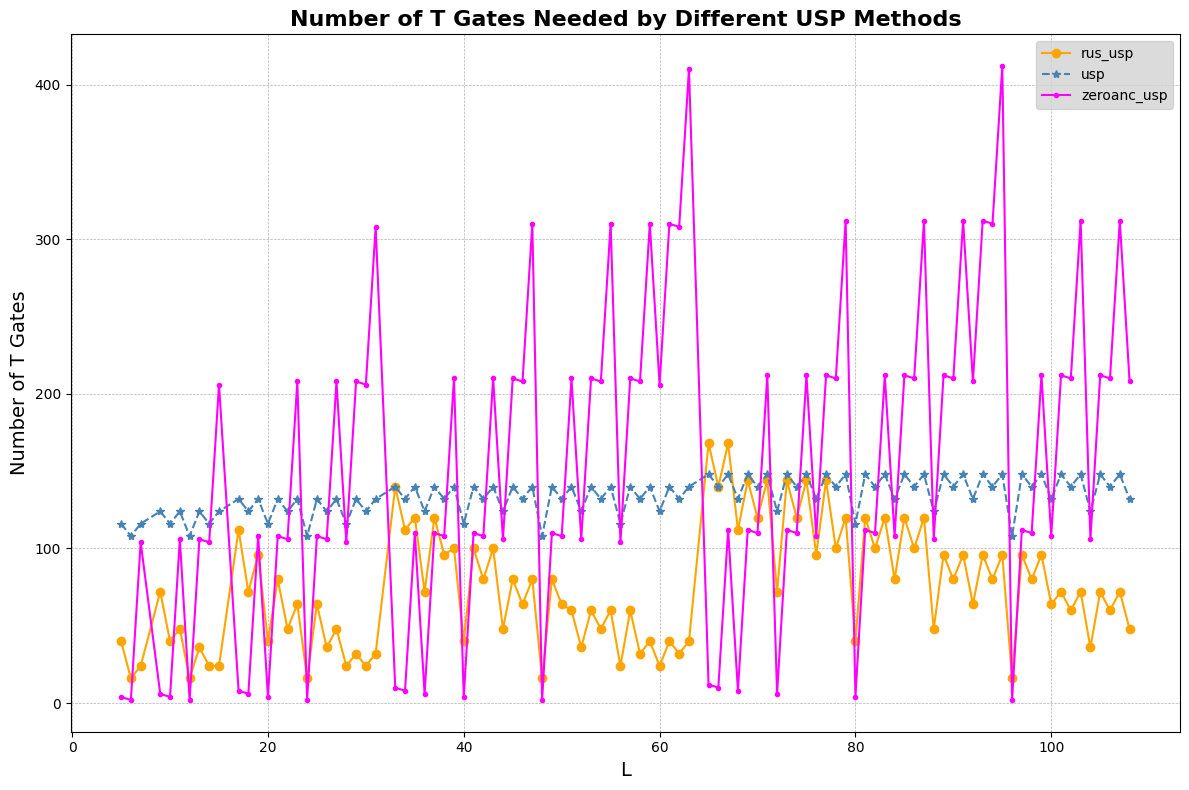

In [281]:
plt.figure(figsize=(12, 8))

plt.plot(L_values, rus_tgates, label="rus_usp", marker="o", color="orange", markersize=6, linestyle="-")
plt.plot(L_values, usp_tgates, label="usp", marker="*", color="steelblue", markersize=6, linestyle="--")
plt.plot(L_values, zeroanc_tgates, label="zeroanc_usp", marker=".", color="magenta", markersize=6, linestyle="-")

plt.title("Number of T Gates Needed by Different USP Methods", fontsize=16, fontweight="bold")
plt.xlabel("L", fontsize=14)
plt.ylabel("Number of T Gates", fontsize=14)

plt.legend(title="Methods", fontsize=12, title_fontsize="13", loc="upper left", frameon=True, edgecolor="black")
plt.legend().get_frame().set_facecolor("lightgrey")

plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()

## Plotting the Results of Ancilla Qubits

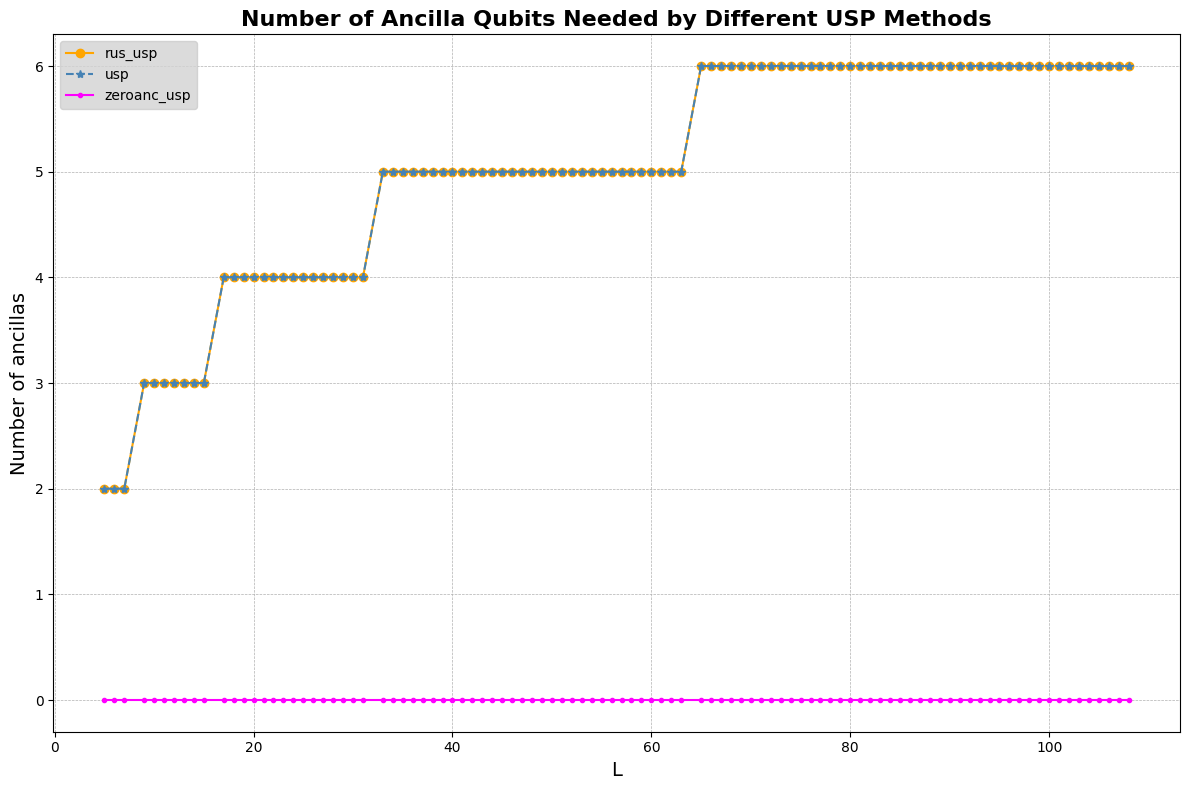

In [282]:
plt.figure(figsize=(12, 8))

plt.plot(L_values, rus_ancilla, label="rus_usp", marker="o", color="orange", markersize=6, linestyle="-")
plt.plot(L_values, usp_ancilla, label="usp", marker="*", color="steelblue", markersize=6, linestyle="--")
plt.plot(L_values, zeroanc_ancilla, label="zeroanc_usp", marker=".", color="magenta", markersize=6, linestyle="-")

plt.title("Number of Ancilla Qubits Needed by Different USP Methods", fontsize=16, fontweight="bold")
plt.xlabel("L", fontsize=14)
plt.ylabel("Number of ancillas", fontsize=14)

plt.legend(title="Methods", fontsize=12, title_fontsize="13", loc="upper left", frameon=True, edgecolor="black")
plt.legend().get_frame().set_facecolor("lightgrey")

plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()

...and we leave the analysis up to you!

## Summary

In this tutorial, we explored the utility of bartiq's resource estimation in more complex scenarios.

- How to effectively utilize BARTIQ to handle nested subroutines
- How to use aggregation functions to synthesize resources